In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import graphviz as gr

# Discussion on Condition on the Positive Bias

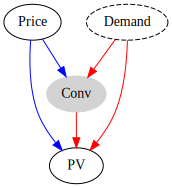

In [2]:
cop_dag = gr.Digraph()

cop_dag.edge("Price", "Conv", color="blue")
cop_dag.edge("Demand", "Conv", color="red")

cop_dag.edge("Demand", "PV", color="red")
cop_dag.edge("Conv", "PV", color="red")
cop_dag.edge("Price", "PV", color="blue")

cop_dag.node("Conv", color="lightgrey", style="filled")
cop_dag.node("Demand", style="dashed")

cop_dag

## DGP

In [3]:
n = 100000

np.random.seed(123)

demand = np.random.normal(0, 1, n)

price = (np.random.beta(1,1, n)*10).astype(int)+1


def conv_fn(price, demand=demand):
    return (np.random.normal(-price + 10*demand, size=n) > 0)*1


def pv_fn(price, demand=demand):
    return 100*demand - 10*price


conversion = conv_fn(price)
pv = pv_fn(price)

df_cop = pd.DataFrame(dict(
    demand=demand,
    price=price,
    conv=conversion,
    pv=pv*conversion,
    **{**{f"conv_{p}": conv_fn(p) for p in np.unique(price)}}
))

df_cop = df_cop.assign(**{f"pv_{p}": df_cop[f"conv_{p}"]*pv_fn(p) for p in np.unique(price)})

df_cop.head()

,demand,price,conv,pv,conv_1,conv_2,conv_3,conv_4,conv_5,conv_6,...,pv_1,pv_2,pv_3,pv_4,pv_5,pv_6,pv_7,pv_8,pv_9,pv_10
0,-1.085631,5,0,-0.000000,0,0,0,0,0,0,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1,0.997345,6,1,39.734545,1,1,1,1,1,1,...,89.734545,79.734545,69.734545,59.734545,49.734545,39.734545,29.734545,19.734545,9.734545,-0.265455
2,0.282978,2,1,8.297850,1,1,1,0,0,0,...,18.297850,8.297850,-1.702150,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
3,-1.506295,9,0,-0.000000,0,0,0,0,0,0,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
4,-0.578600,2,0,-0.000000,0,0,0,0,0,0,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


## Effect on Conversion

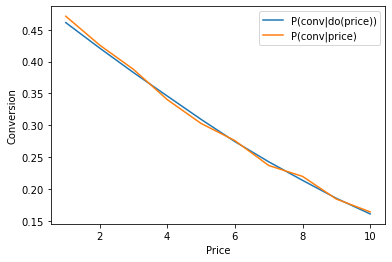

In [4]:
cf_conv_curve = (df_cop[[f"conv_{p}" for p in range(1, 11)]]
                 .melt()
                 .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                 .groupby(["price"])[["value"]].mean())

factual_conv_curve = df_cop.groupby("price")[["conv"]].mean()

plt.plot(cf_conv_curve, label="P(conv|do(price))")
plt.plot(factual_conv_curve, label="P(conv|price)")
plt.ylabel("Conversion")
plt.xlabel("Price")
plt.legend();

## Effect on Purchase Volume

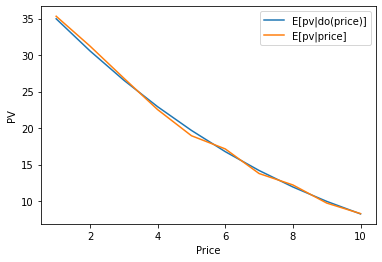

In [5]:
cf_pv_curve = (df_cop[[f"pv_{p}" for p in range(1, 11)]]
                 .melt()
                 .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                 .groupby(["price"])[["value"]].mean())

factual_pv_curve = df_cop.groupby("price")[["pv"]].mean()

plt.plot(cf_pv_curve, label="E[pv|do(price)]")
plt.plot(factual_pv_curve, label="E[pv|price]")
plt.ylabel("PV")
plt.xlabel("Price")
plt.legend();

## Effect on Converted PV

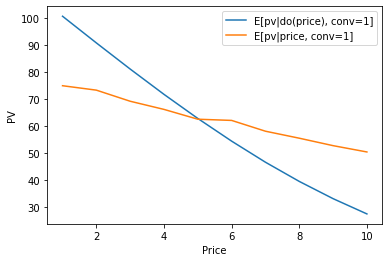

In [6]:
cf_pv_curve_conv = (df_cop
                      .query("conv==1")
                      [[f"pv_{p}" for p in range(1, 11)]]
                      .melt()
                      .assign(price=lambda d: d["variable"].str.split("_").str[-1].astype(int))
                      .groupby(["price"])[["value"]].mean())

factual_pv_curve_conv = (df_cop
                         .query("conv==1")
                         .groupby("price")[["pv"]].mean())

plt.plot(cf_pv_curve_conv, label="E[pv|do(price), conv=1]")
plt.plot(factual_pv_curve_conv, label="E[pv|price, conv=1]")
plt.legend()
plt.ylabel("PV")
plt.xlabel("Price");

In [7]:
np.corrcoef(df_cop["price"], df_cop["demand"])

array([[ 1.        , -0.00377181],
       [-0.00377181,  1.        ]])

In [8]:
np.corrcoef(df_cop.query("conv==1")["price"],
            df_cop.query("conv==1")["demand"])


array([[1.        , 0.34802983],
       [0.34802983, 1.        ]])

## Identifying the Total Effect from COP Data

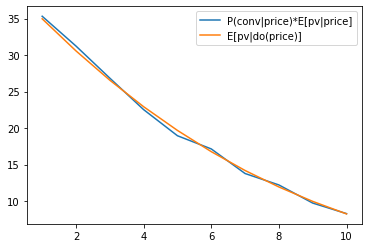

In [9]:
plt.plot(pd.DataFrame(factual_conv_curve.values*factual_pv_curve_conv.values, index=factual_pv_curve_conv.index),
         label="P(conv|price)*E[pv|price]")
plt.plot(cf_pv_curve, label="E[pv|do(price)]")
plt.legend();

$$
\begin{align}
E[pv|price, conv=1]P(conv=1|price) &= E[pv|price, conv=1]P(conv=1|price) + E[pv|price, conv=0]P(conv=0|price) \\
& = E[risk|price]\\
& = E\big[risk|do(price)\big]
\end{align}
$$

### Invariance to Intervention Shift

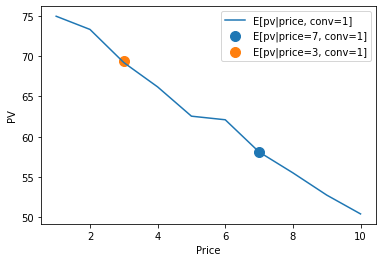

In [10]:
policy_p7 = pv_fn(7)[conv_fn(7) == 1].mean()
policy_p3 = pv_fn(3)[conv_fn(3) == 1].mean()

plt.plot(factual_pv_curve_conv, label="E[pv|price, conv=1]")

plt.scatter(x=[7], y=[policy_p7], label="E[pv|price=7, conv=1]", s=100)
plt.scatter(x=[3], y=[policy_p3], label="E[pv|price=3, conv=1]", s=100)

plt.legend()
plt.ylabel("PV")
plt.xlabel("Price");